In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Engineering

In [28]:
import re
from underthesea import word_tokenize
from sentence_transformers import SentenceTransformer
import numpy as np

# Sử dụng underthesea để tokenize từ tiếng Việt
def tokenize_vi(text):
    return word_tokenize(text, format="text")

# Sử dụng viTALOV để nhúng câu
sent_model_vi = SentenceTransformer('vinai/phobert-base', device='cuda')  # Cần GPU để sử dụng phobert-base

def clean_text(text):
    # Loại bỏ các ký tự đặc biệt chỉ giữ lại chữ cái và số
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

def make_sent_bert_features_vi(text, max_length=768):
    # Kiểm tra xem text có phải là string không
    if not isinstance(text, str):
        # Xử lý nếu text không phải là string (hoặc làm return ngay đây nếu không muốn xử lý)
        return [0.0] * max_length

    # Loại bỏ các ký tự đặc biệt khỏi văn bản
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Giới hạn số lượng ký tự tối đa là 50
    cleaned_text = cleaned_text[:50]

    # Tokenize từ và nhúng câu
    tokenized_text = tokenize_vi(cleaned_text)
    emb = sent_model_vi.encode([tokenized_text])[0]

    if emb is not None:
        padded_emb = emb[:max_length].tolist() + [0.0] * (max_length - len(emb))  # Padding với giá trị 0.0
        return padded_emb
    else:
        return [0.0] * max_length  # Trả về vectơ nhúng chỉ chứa giá trị 0.0 nếu emb là None


# Ví dụ sử dụng
text = "Ví dụ về sửa lỗi!!!"
features = make_sent_bert_features_vi(text)
print(features)

[-0.5100159645080566, 0.05843305215239525, -0.05555471405386925, -0.2901260256767273, -0.5814586281776428, 0.05679112672805786, 0.3154914379119873, -0.4530547559261322, -0.2977263033390045, -0.3013826906681061, -0.02195950411260128, 0.09361977875232697, 0.08398748189210892, -0.11025035381317139, -0.11767343431711197, -0.06148625537753105, -0.025686128064990044, 0.08235841244459152, -0.3943684697151184, -0.06675510853528976, -0.018051374703645706, -0.241013765335083, 0.524624228477478, 0.39619478583335876, 0.018438590690493584, -0.024362212046980858, 0.36304670572280884, 0.1404869258403778, 0.15418051183223724, 0.2269289791584015, -0.1180373877286911, 0.200776606798172, -0.008722811006009579, 0.30370402336120605, 0.3776337504386902, 0.1723538190126419, 0.3871268332004547, -0.43311482667922974, -0.02771562710404396, 0.2777871787548065, 0.22531673312187195, 0.0572529099881649, -0.07053112983703613, -0.5543681383132935, -0.1043444499373436, -0.030028557404875755, -0.21706749498844147, -0.0

In [35]:
import os
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.data import DataLoader

# Đường dẫn đến thư mục chứa các file CSV
folder_path = '/content/drive/MyDrive/graph/output_folder9'  # Chú ý sử dụng hai dấu \\ hoặc raw string để tránh xử lý đặc biệt

# Sử dụng CPU nếu không tìm thấy GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
def process_csv_file(file_path):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(file_path)

    # Mapping giữa nhãn str và int
    label_mapping = {
        'noiph': 0,
        'ngayph': 1,
        'sovb': 2,
        'tenvb': 3,
        'khongxd': 4,
        'CNXH': 5,
        'den': 6,
        'noigui': 7,
        'noinhan': 8
    }

    # Tạo đồ thị từ dữ liệu
    G = nx.Graph()

    # Thêm node với tọa độ và thuộc tính
    for _, row in df.iterrows():
        node_label = label_mapping[row['Object']]
        G.add_node(node_label, x=(row['xmin'] + row['xmax']) / 2, y=(row['ymin'] + row['ymax']) / 2, attributes=row[5:])

    for node_label in range(9):
        if node_label not in G.nodes:
          G.add_node(node_label, x=0, y=0, attributes=[None])
    # Thêm cạnh với thuộc tính
    for _, row in df.iterrows():
        source_node = label_mapping[row['Object']]
        below_node = label_mapping.get(row['below_object'], None)
        side_node = label_mapping.get(row['side_object'], None)

        if below_node is not None:
            edge_data = {'below_dist': row['below_dist']}
            G.add_edge(source_node, below_node, **edge_data)

        if side_node is not None:
            edge_data = {'side_length': row['side_length']}
            G.add_edge(source_node, side_node, **edge_data)

    # Chuyển đổi đồ thị sang định dạng PyTorch Geometric
    edge_index = torch.tensor(list(G.edges)).t().contiguous()

    x = torch.tensor([(G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes], dtype=torch.float)
    edge_attr = torch.tensor([G.edges[edge]['below_dist'] if 'below_dist' in G.edges[edge] else G.edges[edge]['side_length'] if 'side_length' in G.edges[edge] else 0 for edge in G.edges], dtype=torch.float).view(-1, 1)

    # Tạo một tensor nhãn 'y' với giá trị là nhãn của mỗi dòng
    unique_labels_set = set()  # Sử dụng set để lưu trữ các giá trị đã xuất hiện
    unique_y = [None] * 9  # Tạo một list với giá trị None cho tất cả 9 nodes

    # Lặp qua từng dòng trong DataFrame và kiểm tra xem giá trị đã xuất hiện hay chưa
    for _, row in df.iterrows():
        label = label_mapping[row['Object']]
        unique_y[label] = label

    # Thay thế giá trị None bằng một giá trị đặc biệt (ví dụ: -1)
    unique_y = [4 if label is None else label for label in unique_y]
    # Chuyển đổi list thành tensor
    y = torch.tensor(unique_y, dtype=torch.long)
    print(y)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    # Tạo một list các vectơ nhúng
    text_features_vi = df["text_extraction"].map(make_sent_bert_features_vi).tolist()

    # Lấy độ dài tối đa của vectơ nhúng
    max_length = max(len(vec) for vec in text_features_vi)

    # Padding các vectơ nhúng để có kích thước đồng đều
    text_features_padded = [vec + [0.0] * (max_length - len(vec)) for vec in text_features_vi]

    # Chuyển đổi thành tensor PyTorch 3D
    text_features_vi_tensor = torch.tensor(text_features_padded, dtype=torch.float32, device=device)

    # Nếu text_features_vi_tensor đang ở trên GPU (cuda), chuyển data.x về cuda
    if text_features_vi_tensor.is_cuda:
        data.x = data.x.to('cpu')

    # Nếu text_features_vi_tensor đang ở trên CPU (cpu), chuyển text_features_vi_tensor về cuda
    if not text_features_vi_tensor.is_cuda:
        text_features_vi_tensor = text_features_vi_tensor.to('cpu')

    # Giữ lại tất cả 9 dòng từ text_features_vi_tensor
    text_features_vi_tensor = text_features_vi_tensor[:data.x.shape[0], :]

    # Nếu text_features_vi_tensor có ít hơn 9 dòng, thêm các dòng còn thiếu
    if text_features_vi_tensor.size(0) < 9:
        padding_rows = 9 - text_features_vi_tensor.size(0)
        text_features_vi_tensor = torch.cat([text_features_vi_tensor, torch.zeros(padding_rows, text_features_vi_tensor.size(1)).to('cpu')], dim=0)

    # Nối tensor
    data.x = torch.cat([data.x, text_features_vi_tensor], dim=1)

    return data


# Xử lý tất cả các file CSV trong thư mục
all_data = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        data = process_csv_file(file_path)
        all_data.append(data)

# Gộp tất cả dữ liệu thành một đối tượng DataLoader (tùy thuộc vào cách bạn muốn tổ chức dữ liệu)
# DataLoader là một đối tượng PyTorch Geometric hỗ trợ batch training
loader = DataLoader(all_data, batch_size=1, shuffle=True)

tensor([0, 1, 2, 3, 4, 5, 4, 4, 8])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 6, 4, 8])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 8])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 6, 4, 8])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 6, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 6, 4, 8])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 6, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 4])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 8])
tensor([0, 1, 2, 3, 4, 5, 4, 4, 8])
tensor([0, 1, 2, 3, 4, 5, 4,

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [36]:
all_data

[Data(x=[9, 770], edge_index=[2, 8], edge_attr=[8, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 9], edge_attr=[9, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 8], edge_attr=[8, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 11], edge_attr=[11, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 8], edge_attr=[8, 1], y=[9]),
 Data(x=[9, 770], edge_index=[2, 10], edge_attr=[10, 

In [37]:
from sklearn.model_selection import train_test_split
# Chia dữ liệu thành tập huấn luyện (90%) và tập kiểm thử (10%)
train_data, test_data = train_test_split(all_data, test_size=0.1, random_state=42)

# In kích thước của tập huấn luyện và tập kiểm thử
print(f'Train set size: {len(train_data)} samples')
print(f'Test set size: {len(test_data)} samples')

Train set size: 27 samples
Test set size: 3 samples


In [38]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, PNAConv, SGConv
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import torchvision.transforms as transforms


def train_model(model, optimizer, criterion, scheduler, train_data, test_data, num_epochs=300):
    train_losses = []  # To store training loss values for each epoch
    test_losses = []   # To store testing loss values for each epoch
    all_preds = []
    all_labels = []
    model.to(device)
    train_data = [data.to(device) for data in train_data]
    test_data = [data.to(device) for data in test_data]
    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0
        for data in train_data:
            optimizer.zero_grad()
            out = model(data)
            labels = data.y.to(device)  # Use data.y as the actual labels from your data
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Testing
        model.eval()
        total_test_loss = 0

        with torch.no_grad():
            for data in test_data:
                out = model(data)
                labels = data.y  # Use data.y as the actual labels from your data
                loss = criterion(out, labels)
                total_test_loss += loss.item()

                preds = torch.argmax(out, dim=1)
                all_preds.extend(preds.tolist())
                all_labels.extend(labels.tolist())

        # Adjust learning rate based on the training loss
        scheduler.step(total_train_loss)

        # Print average training and testing loss for each epoch
        average_train_loss = total_train_loss / len(train_data)
        average_test_loss = total_test_loss / len(test_data)
        print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss}, Test Loss: {average_test_loss}')

        # Save loss values for plotting later
        train_losses.append(average_train_loss)
        test_losses.append(average_test_loss)

    return train_losses, test_losses, all_labels, all_preds

def visualize_results(train_losses, test_losses):
    # Plot the training loss and testing loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    return accuracy,recall,precision,f1

# GCN

Epoch 1, Train Loss: 3.349750836690267, Test Loss: 2.2416881720225015
Epoch 2, Train Loss: 1.9598614816312436, Test Loss: 1.9394356807072957
Epoch 3, Train Loss: 1.6610265661168981, Test Loss: 1.7875690062840779
Epoch 4, Train Loss: 1.5038470250588876, Test Loss: 1.6816681226094563
Epoch 5, Train Loss: 1.3642803033192952, Test Loss: 1.6016838947931926
Epoch 6, Train Loss: 1.2721695877887584, Test Loss: 1.5314218997955322
Epoch 7, Train Loss: 1.1638492478264704, Test Loss: 1.4303139448165894
Epoch 8, Train Loss: 1.061988561241715, Test Loss: 1.3550774256388347
Epoch 9, Train Loss: 0.9474634439856918, Test Loss: 1.4125089645385742
Epoch 10, Train Loss: 0.919889560452214, Test Loss: 1.2743350664774578
Epoch 11, Train Loss: 0.8785911390074977, Test Loss: 1.2204655011494954
Epoch 12, Train Loss: 0.8340306083361307, Test Loss: 1.2440810998280842
Epoch 13, Train Loss: 0.793936507569419, Test Loss: 1.1887868642807007
Epoch 14, Train Loss: 0.7992923038977163, Test Loss: 1.3039254744847615
Epoch

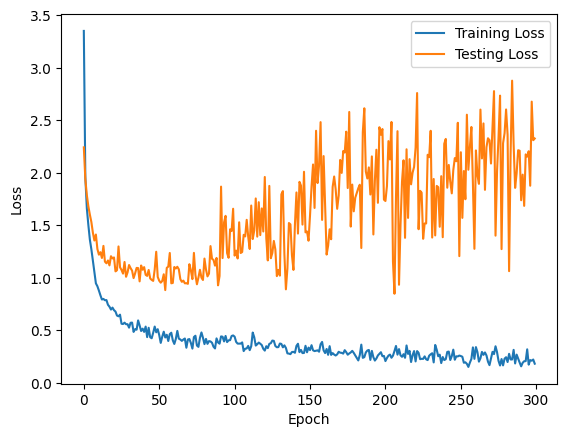

Final Loss on GCN model: 2.3259333868821463


In [39]:
# Define the Graph Convolutional Network (GCN) model_GCN
class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
        super(GCNModel, self).__init__()

        self.conv1 = GCNConv(in_channels=num_features, out_channels=hidden_size)
        self.conv2 = GCNConv(in_channels=hidden_size, out_channels=num_classes)
        self.linear = nn.Linear(num_classes, num_classes)  # Đảm bảo rằng số lượng đặc trưng của lớp tuyến tính là num_classes
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.linear(x)  # Áp dụng lớp tuyến tính
        return x

# Initialize the GCN model_GCN, optimizer_GCN, and criterion_GCN
model_GCN = GCNModel(num_features=770, hidden_size=8, num_classes=9, dropout_rate=0.05)
model_GCN.to(device)
optimizer_GCN = optim.Adam(model_GCN.parameters(), lr=0.002, weight_decay=1e-5)
criterion_GCN = nn.CrossEntropyLoss()

# Learning rate scheduler_GCN
scheduler_GCN = ReduceLROnPlateau(optimizer_GCN, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

# Assuming you have train_data and test_data defined before
train_losses_GCN, test_losses_GCN, all_labels_GCN, all_preds_GCN = train_model(model_GCN, optimizer_GCN, criterion_GCN, scheduler_GCN, train_data, test_data)

# Visualize the training and testing results
visualize_results(train_losses_GCN, test_losses_GCN)

final_loss_GCN = test_losses_GCN[-1]
print(f'Final Loss on GCN model: {final_loss_GCN}')
accuracy_GCN, recall_GCN, prec_GCN, f1_GCN = evaluate(all_labels_GCN, all_preds_GCN)

# GAT

Epoch 1, Train Loss: 13.073388594168204, Test Loss: 7.1961595217386884
Epoch 2, Train Loss: 3.9280653441393816, Test Loss: 3.9186699390411377
Epoch 3, Train Loss: 2.3653004699283176, Test Loss: 2.84439484278361
Epoch 4, Train Loss: 1.9871964675408822, Test Loss: 2.577667991320292
Epoch 5, Train Loss: 1.8626025628160547, Test Loss: 2.404323101043701
Epoch 6, Train Loss: 1.5916422914575648, Test Loss: 2.2188907861709595
Epoch 7, Train Loss: 1.5240556443179096, Test Loss: 2.155791481335958
Epoch 8, Train Loss: 1.4430722307275843, Test Loss: 2.0600105126698813
Epoch 9, Train Loss: 1.3918537320914093, Test Loss: 2.0118555227915444
Epoch 10, Train Loss: 1.2697325790369953, Test Loss: 1.935277263323466
Epoch 11, Train Loss: 1.1644200483957927, Test Loss: 1.8833026488622029
Epoch 12, Train Loss: 1.1815246211157904, Test Loss: 1.8291715383529663
Epoch 13, Train Loss: 1.0968247618940141, Test Loss: 1.7392745812733967
Epoch 14, Train Loss: 1.118176934895692, Test Loss: 1.6606556177139282
Epoch 15

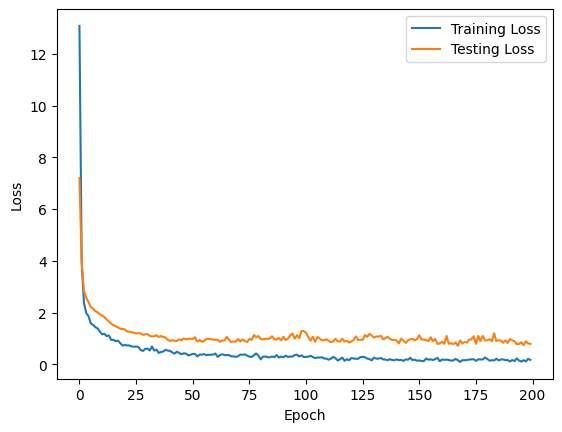

Final Loss on GAT model: 0.7955362498760223


In [40]:
# Define a GAT model_GAT
class GATModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5, heads=1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(num_features, hidden_size, heads=heads, dropout=dropout_rate)
        self.conv2 = GATConv(hidden_size * heads, num_classes, heads=1, concat=False, dropout=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the GAT model_GAT, optimizer_GAT, and criterion_GAT
model_GAT = GATModel(num_features=770, hidden_size=16, num_classes=9, dropout_rate=0.05, heads=2)
optimizer_GAT = optim.Adam(model_GAT.parameters(), lr=0.001, weight_decay=1e-5)
criterion_GAT = nn.CrossEntropyLoss()

# Learning rate scheduler_GAT
scheduler_GAT = ReduceLROnPlateau(optimizer_GAT, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

# Assuming you have train_data and test_data defined before
train_losses_GAT, test_losses_GAT, all_labels_GAT, all_preds_GAT = train_model(model_GAT, optimizer_GAT, criterion_GAT, scheduler_GAT, train_data, test_data, num_epochs=200)

# Visualize the training and testing results
visualize_results(train_losses_GAT, test_losses_GAT)
final_loss_GAT = test_losses_GAT[-1]
print(f'Final Loss on GAT model: {final_loss_GAT}')
accuracy_GAT, recall_GAT, prec_GAT, f1_GAT = evaluate(all_labels_GAT, all_preds_GAT)

# SAGE

Epoch 1, Train Loss: 3.2081529564327664, Test Loss: 1.9960615634918213
Epoch 2, Train Loss: 1.377755253403275, Test Loss: 1.3798506657282512
Epoch 3, Train Loss: 1.0396484379415158, Test Loss: 1.175673007965088
Epoch 4, Train Loss: 0.8898259048108701, Test Loss: 1.0438133676846821
Epoch 5, Train Loss: 0.7946317449763969, Test Loss: 0.9577065110206604
Epoch 6, Train Loss: 0.7308569064846745, Test Loss: 0.8914444049199423
Epoch 7, Train Loss: 0.6735392753724698, Test Loss: 0.8744058609008789
Epoch 8, Train Loss: 0.6208355415750433, Test Loss: 0.8684466481208801
Epoch 9, Train Loss: 0.5706614228310408, Test Loss: 0.8602795600891113
Epoch 10, Train Loss: 0.5262714403646963, Test Loss: 0.8829877773920695
Epoch 11, Train Loss: 0.488944822439441, Test Loss: 0.8732288678487142
Epoch 12, Train Loss: 0.45260063117301025, Test Loss: 0.863294800122579
Epoch 13, Train Loss: 0.4153972052865558, Test Loss: 0.7504955132802328
Epoch 14, Train Loss: 0.38762250639222284, Test Loss: 0.7329835295677185
Epo

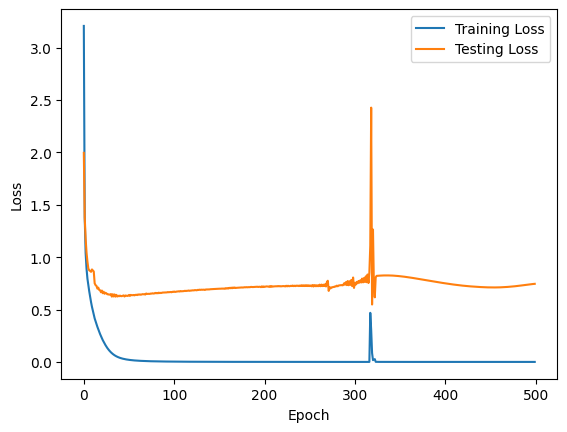

Final Loss on GSAGE model: 0.7455811413625876


In [41]:
# Define the GraphSAGE model_GSAGE
class GraphSAGEModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_size)
        self.conv2 = SAGEConv(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)

        return x

# Initialize the GAT model_GSAGE, optimizer_GSAGE, and criterion_GSAGE
model_GSAGE = GraphSAGEModel(num_features=770, hidden_size=16, num_classes=9, dropout_rate=0.05)
optimizer_GSAGE = optim.Adam(model_GSAGE.parameters(), lr=0.001, weight_decay=1e-5)
criterion_GSAGE = nn.CrossEntropyLoss()

# Learning rate scheduler_GSAGE
scheduler_GSAGE = ReduceLROnPlateau(optimizer_GSAGE, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

# Assuming you have train_data and test_data defined before
train_losses_GSAGE, test_losses_GSAGE, all_labels_GSAGE, all_preds_GSAGE = train_model(model_GSAGE, optimizer_GSAGE, criterion_GSAGE, scheduler_GSAGE, train_data, test_data,num_epochs=500)

# Visualize the training and testing results
visualize_results(train_losses_GSAGE, test_losses_GSAGE)
final_loss_GSAGE = test_losses_GSAGE[-1]
print(f'Final Loss on GSAGE model: {final_loss_GSAGE}')
accuracy_GSAGE, recall_GSAGE, prec_GSAGE, f1_GSAGE = evaluate(all_labels_GSAGE, all_preds_GSAGE)

# PNAConv

Epoch 1, Train Loss: 2.128328636840538, Test Loss: 2.0071198542912803
Epoch 2, Train Loss: 1.6466936932669745, Test Loss: 1.9677963654200237
Epoch 3, Train Loss: 1.4410958135569538, Test Loss: 1.6394980351130168
Epoch 4, Train Loss: 1.3424567734753643, Test Loss: 2.5734473864237466
Epoch 5, Train Loss: 1.4043121933937073, Test Loss: 1.6182857950528462
Epoch 6, Train Loss: 1.0487759466524478, Test Loss: 1.4330817262331645
Epoch 7, Train Loss: 0.8492874160960868, Test Loss: 1.5459867616494496
Epoch 8, Train Loss: 0.6908693103878586, Test Loss: 1.2136062781016033
Epoch 9, Train Loss: 0.5411934366932621, Test Loss: 2.0922282536824546
Epoch 10, Train Loss: 0.6496124038541758, Test Loss: 0.9995543758074442
Epoch 11, Train Loss: 0.46121328806987516, Test Loss: 1.2689590901136398
Epoch 12, Train Loss: 1.1303084776909262, Test Loss: 9.897122184435526
Epoch 13, Train Loss: 2.9309676112952054, Test Loss: 1.503419001897176
Epoch 14, Train Loss: 1.2410200745971114, Test Loss: 1.4791745742162068
Epo

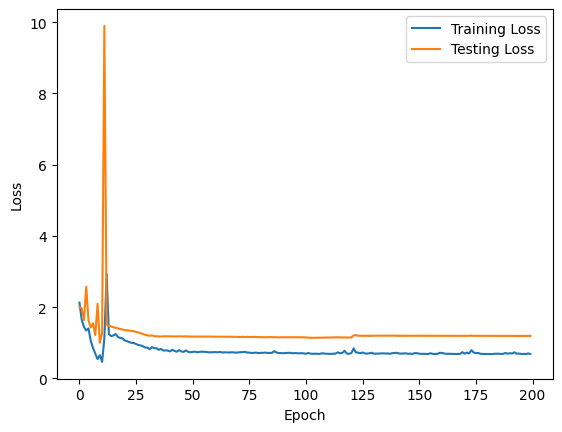

Final Loss on PNA model: 1.1922187407811482


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# Define the PNAConv model
class PNAConvModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
        super(PNAConvModel, self).__init__()

        # Make sure deg is a PyTorch tensor
        deg = torch.tensor(1.0)  # You may need to adjust the value based on your requirements

        # Make sure scalers is a list of strings
        scalers = ['identity', 'identity', 'identity']

        self.conv1 = PNAConv(in_channels=num_features, out_channels=hidden_size, heads=4, flow='source_to_target', aggregators=['mean', 'min', 'max'], scalers=scalers, deg=deg)
        self.conv2 = PNAConv(in_channels=hidden_size, out_channels=hidden_size, heads=4, flow='source_to_target', aggregators=['mean', 'min', 'max'], scalers=scalers, deg=deg)
        self.conv3 = PNAConv(in_channels=hidden_size, out_channels=num_classes, heads=4, flow='target_to_source', aggregators=['mean', 'min', 'max'], scalers=scalers, deg=deg)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

# Initialize the PNAConv model, optimizer_PNA, and criterion_PNA
model_PNA = PNAConvModel(num_features=770, hidden_size=8, num_classes=9, dropout_rate=0.1)
optimizer_PNA = optim.Adam(model_PNA.parameters(), lr=0.002, weight_decay=1e-5)
criterion_PNA = nn.CrossEntropyLoss()

# Learning rate scheduler_PNA
scheduler_PNA = ReduceLROnPlateau(optimizer_PNA, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

# Assuming you have train_data and test_data defined before
train_losses_PNA, test_losses_PNA, all_labels_PNA, all_preds_PNA = train_model(model_PNA, optimizer_PNA, criterion_PNA, scheduler_PNA, train_data, test_data, num_epochs = 200)

# Visualize the training and testing results
visualize_results(train_losses_PNA, test_losses_PNA)

final_loss_PNA = test_losses_PNA[-1]
print(f'Final Loss on PNA model: {final_loss_PNA}')
accuracy_PNA, recall_PNA, prec_PNA, f1_PNA = evaluate(all_labels_PNA, all_preds_PNA)

# SGConv

Epoch 1, Train Loss: 2.542915838736075, Test Loss: 2.072833021481832
Epoch 2, Train Loss: 1.9590968158509996, Test Loss: 2.0369873046875
Epoch 3, Train Loss: 1.847632059344539, Test Loss: 1.9602956374486287
Epoch 4, Train Loss: 1.7833463924902457, Test Loss: 1.9059934218724568
Epoch 5, Train Loss: 1.6567861018357453, Test Loss: 1.9260762532552083
Epoch 6, Train Loss: 1.58157984857206, Test Loss: 1.8108920653661091
Epoch 7, Train Loss: 1.526056002687525, Test Loss: 1.7529386679331462
Epoch 8, Train Loss: 1.4102616795787104, Test Loss: 1.7401523192723591
Epoch 9, Train Loss: 1.440452769950584, Test Loss: 1.674560825030009
Epoch 10, Train Loss: 1.2897652409694813, Test Loss: 1.634830633799235
Epoch 11, Train Loss: 1.24545407515985, Test Loss: 1.583033561706543
Epoch 12, Train Loss: 1.242715879722878, Test Loss: 1.6650724013646443
Epoch 13, Train Loss: 1.1687681917791013, Test Loss: 1.5294469992319744
Epoch 14, Train Loss: 1.091563348416929, Test Loss: 1.5312336285909016
Epoch 15, Train Lo

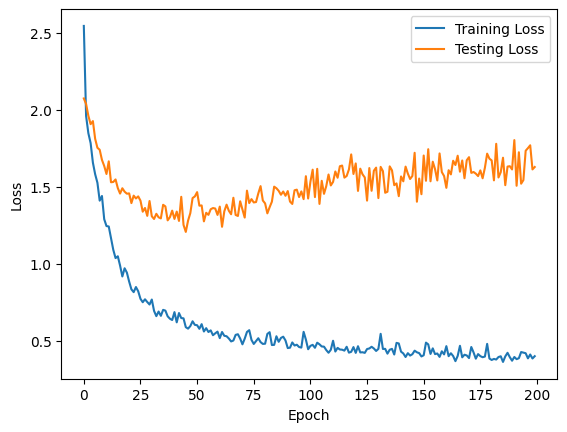

Final Loss on GAT model: 1.6283366680145264


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Define the SGConv model_SGC
class SGConvModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
        super(SGConvModel, self).__init__()

        self.conv1 = SGConv(in_channels=num_features, out_channels=hidden_size, K=2)
        self.conv2 = SGConv(in_channels=hidden_size, out_channels=num_classes, K=2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the SGConv model, optimizer_SGC, and criterion_SGC
model_SGC = SGConvModel(num_features=770, hidden_size=16, num_classes=9, dropout_rate=0.05)
optimizer_SGC = optim.Adam(model_SGC.parameters(), lr=0.001, weight_decay=1e-5)
criterion_SGC = nn.CrossEntropyLoss()

# Learning rate scheduler_SGC
scheduler_SGC = ReduceLROnPlateau(optimizer_SGC, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

train_losses_SGC, test_losses_SGC, all_labels_SGC, all_preds_SGC = train_model(model_SGC, optimizer_SGC, criterion_SGC, scheduler_SGC, train_data, test_data, num_epochs=200)

# Visualize the training and testing results
visualize_results(train_losses_SGC, test_losses_SGC)

final_loss_SGC = test_losses_SGC[-1]
print(f'Final Loss on GAT model: {final_loss_SGC}')
accuracy_SGC, recall_SGC, prec_SGC, f1_SGC = evaluate(all_labels_SGC, all_preds_SGC)

# Test

In [44]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data

def process_csv_test_file(file_path):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(file_path)

    # Tạo đồ thị từ dữ liệu
    G = nx.Graph()

    # Thêm node với tọa độ và thuộc tính
    for _, row in df.iterrows():
        # Không cần thiết lập nhãn (label) của node, chỉ sử dụng số thứ tự làm nhãn
        G.add_node(_, x=(row['xmin'] + row['xmax']) / 2, y=(row['ymin'] + row['ymax']) / 2, attributes=row[5:])
    for _ in range(9):
          G.add_node(_, x=0, y=0, attributes=[None] * (len(df.columns) - 5))
    # Thêm cạnh với thuộc tính
    for _, row in df.iterrows():
        source_node = _
        below_node = row['below_obj_index']
        side_node = row['side_obj_index']

        if below_node != -1:
            edge_data = {'below_dist': row['below_dist']}
            G.add_edge(source_node, below_node, **edge_data)

        if side_node != -1:
            edge_data = {'side_length': row['side_length']}
            G.add_edge(source_node, side_node, **edge_data)

    # Vẽ đồ thị (tùy chọn)
    # nx.draw(G, with_labels=True)
    # plt.show()

    # Chuyển đổi đồ thị sang định dạng PyTorch Geometric
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = torch.tensor([(G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes], dtype=torch.float)
    edge_attr = torch.tensor([G.edges[edge]['below_dist'] if 'below_dist' in G.edges[edge] else G.edges[edge]['side_length'] for edge in G.edges], dtype=torch.float).view(-1, 1)
    y = None
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

  # Tạo một list các vectơ nhúng
    text_features_vi = df["text_extraction"].map(make_sent_bert_features_vi).tolist()

    # Lấy độ dài tối đa của vectơ nhúng
    max_length = max(len(vec) for vec in text_features_vi)

    # Padding các vectơ nhúng để có kích thước đồng đều
    text_features_padded = [vec + [0.0] * (max_length - len(vec)) for vec in text_features_vi]

    # Chuyển đổi thành tensor PyTorch 3D
    text_features_vi_tensor = torch.tensor(text_features_padded, dtype=torch.float32, device=device)

    # Nếu text_features_vi_tensor đang ở trên GPU (cuda), chuyển data.x về cuda
    if text_features_vi_tensor.is_cuda:
        data.x = data.x.to('cpu')

    # Nếu text_features_vi_tensor đang ở trên CPU (cpu), chuyển text_features_vi_tensor về cuda
    if not text_features_vi_tensor.is_cuda:
        text_features_vi_tensor = text_features_vi_tensor.to('cpu')

    # Giữ lại tất cả 9 dòng từ text_features_vi_tensor
    text_features_vi_tensor = text_features_vi_tensor[:data.x.shape[0], :]

    # Nếu text_features_vi_tensor có ít hơn 9 dòng, thêm các dòng còn thiếu
    if text_features_vi_tensor.size(0) < 9:
        padding_rows = 9 - text_features_vi_tensor.size(0)
        text_features_vi_tensor = torch.cat([text_features_vi_tensor, torch.zeros(padding_rows, text_features_vi_tensor.size(1)).to('cpu')], dim=0)

    # Nối tensor
    data.x = torch.cat([data.x, text_features_vi_tensor], dim=1)

    return data

# Sử dụng hàm với đường dẫn tới file CSV
file_path = "/content/drive/MyDrive/graph/labels_test1.csv"
processed_data = process_csv_test_file(file_path)

In [45]:
processed_data

Data(x=[9, 770], edge_index=[2, 7], edge_attr=[7, 1])

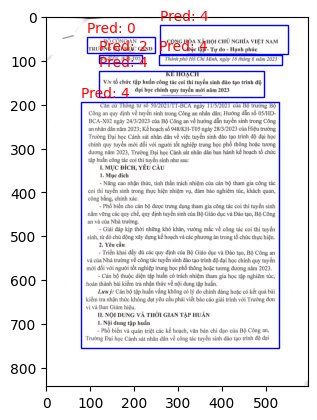

In [46]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

# Đọc file CSV
csv_file = '/content/drive/MyDrive/graph/labels_test1.csv'  # Thay đổi đường dẫn và tên file CSV của bạn
data = pd.read_csv(csv_file)

# Đọc ảnh đầu vào
image_path = '/content/drive/MyDrive/graph/page_1.png'  # Thay đổi đường dẫn và tên ảnh của bạn
image = cv2.imread(image_path)

# Dự đoán nhãn cho dữ liệu
with torch.no_grad():
    out = model_GSAGE(process_csv_test_file(csv_file).to(device))
predicted_labels = torch.argmax(out, dim=1)

# Tạo subplot và hiển thị ảnh
fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Vẽ bounding box trên ảnh với nhãn đã được dự đoán
for index, (row, predicted_label) in enumerate(zip(data.iterrows(), predicted_labels)):
    object_label = f'Pred: {predicted_label.item()}'  # Sử dụng nhãn đã được dự đoán
    xmin, ymin, xmax, ymax = int(row[1]['xmin']), int(row[1]['ymin']), int(row[1]['xmax']), int(row[1]['ymax'])

    # Vẽ bounding box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

    # Gán nhãn
    label = f'{object_label}'
    plt.text(xmin, ymin - 10, label, color='r')

# Hiển thị ảnh với bounding box và nhãn dự đoán
plt.show()

# Visualize Results

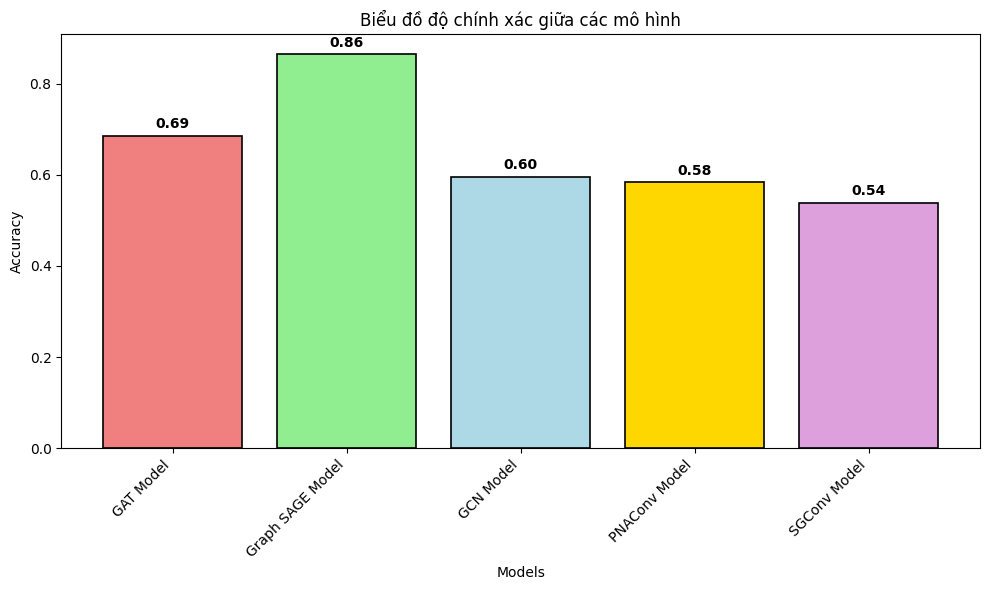

In [47]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNAConv Model', 'SGConv Model']
values = [accuracy_GAT, accuracy_GSAGE, accuracy_GCN, accuracy_PNA, accuracy_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ độ chính xác giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

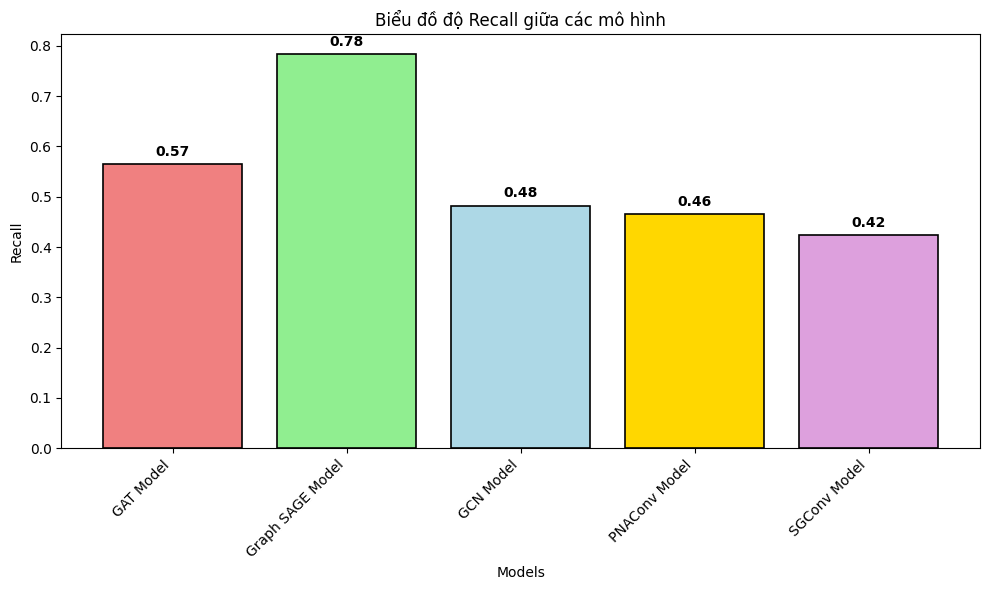

In [48]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNAConv Model', 'SGConv Model']
values = [recall_GAT, recall_GSAGE, recall_GCN, recall_PNA, recall_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ độ Recall giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('Recall')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

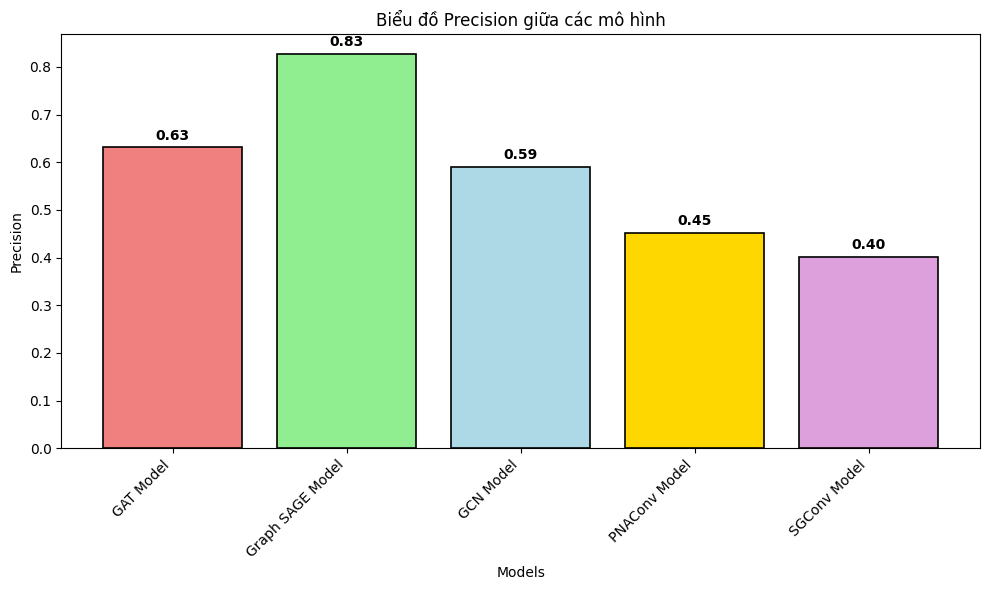

In [49]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNAConv Model', 'SGConv Model']
values = [prec_GAT, prec_GSAGE, prec_GCN, prec_PNA, prec_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ Precision giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('Precision')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

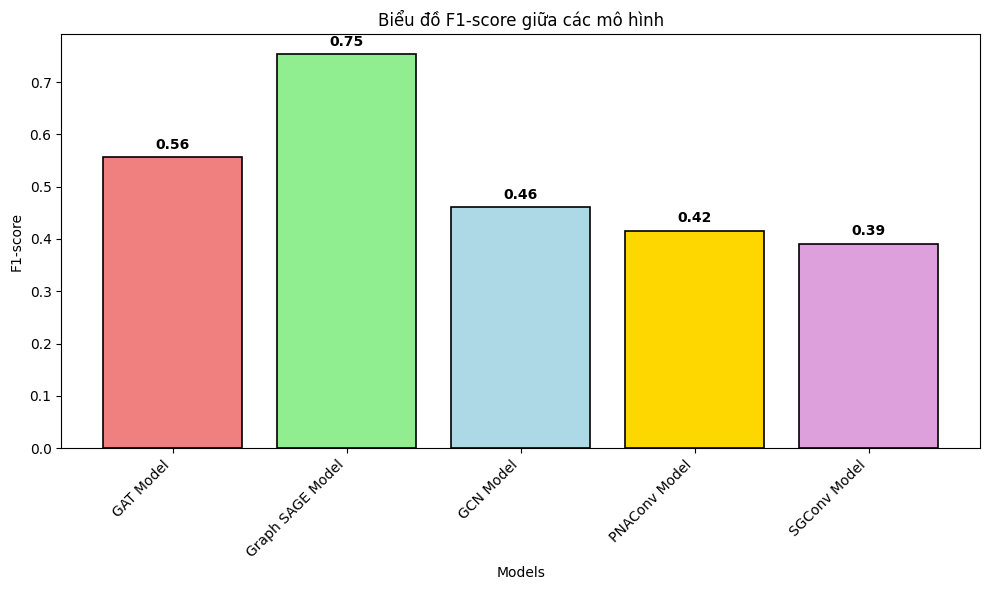

In [50]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNAConv Model', 'SGConv Model']
values = [f1_GAT, f1_GSAGE, f1_GCN, f1_PNA, f1_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ F1-score giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('F1-score')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

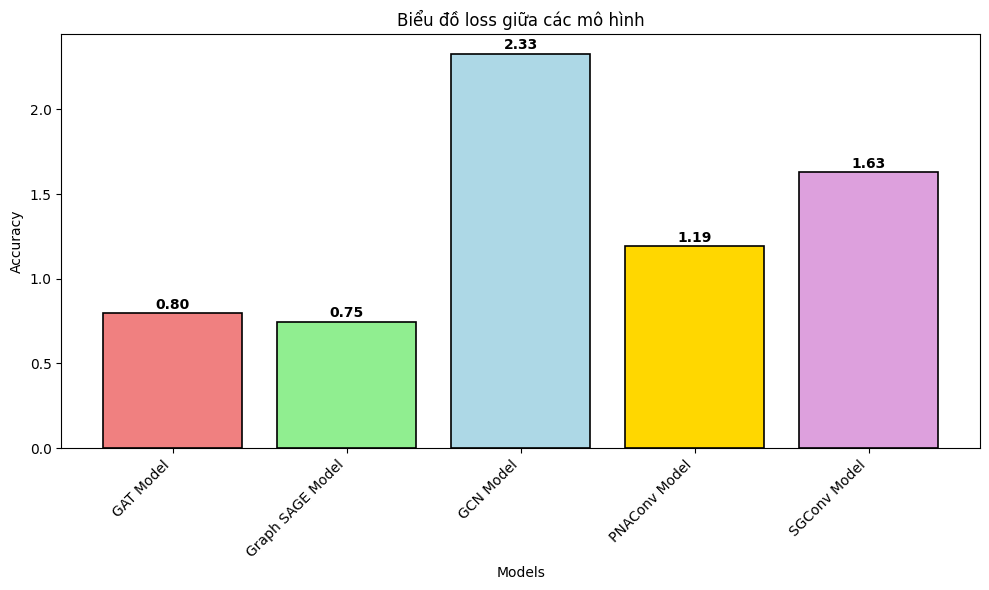

In [51]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNAConv Model', 'SGConv Model']
values = [final_loss_GAT, final_loss_GSAGE, final_loss_GCN, final_loss_PNA, final_loss_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ loss giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()